In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import defaultdict
from hashable import *

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def center_position(points):
    c = np.mean(points, axis=0)
    assert len(c) == len(points[0])
    return c

In [3]:
def som_step(centers,data,neighbor,eta,sigma):
    """Performs one step of the sequential learning for a 
    self-organized map (SOM).
    
      centers = som_step(centers,data,neighbor,eta,sigma)
    
      Input and output arguments: 
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (vector) the actually presented datapoint to be presented in
                         this timestep
       neighbor (matrix) the coordinates of the centers in the desired
                         neighborhood.
       eta      (scalar) a learning rate
       sigma    (scalar) the width of the gaussian neighborhood function.
                         Effectively describing the width of the neighborhood
    """
    
    size_k = int(np.sqrt(len(centers)))
    
    #find the best matching unit via the minimal distance to the datapoint
    b = np.argmin(np.sum((centers - np.resize(data, (size_k**2, data.size)))**2,1))

    # find coordinates of the winner
    a,b = np.nonzero(neighbor == b)
        
    # update all units
    for j in range(size_k**2):
        # find coordinates of this unit
        a1,b1 = np.nonzero(neighbor==j)
        # calculate the distance and discounting factor
        disc=gauss(np.sqrt((a-a1)**2+(b-b1)**2),[0, sigma])
        # update weights        
        centers[j,:] += disc * eta * (data - centers[j,:])
        

In [4]:
def name2digits(name):
    """ takes a string NAME and converts it into a pseudo-random selection of 4
     digits from 0-9.
     
     Example:
     name2digits('Felipe Gerhard')
     returns: [0 4 5 7]
     """
    
    name = name.lower()
    
    if len(name)>25:
        name = name[0:25]
        
    primenumbers = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]
    
    n = len(name)
    
    s = 0.0
    
    for i in range(n):
        s += primenumbers[i]*ord(name[i])*2.0**(i+1)

    import scipy.io.matlab
    Data = scipy.io.matlab.loadmat('hash.mat',struct_as_record=True)
    x = Data['x']
    t = np.mod(s,x.shape[0])

    return np.sort(x[t,:])

In [5]:
def gauss(x,p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))

In [6]:
def init_center_movment_dict(centers):
    d = {}
    for i in range(0, len(centers)):
        d[i] = (100, centers[i])
    return d

In [7]:
def update_center_movment(center_movment_dict, current_centers, t):
    """
    center_movment_dict: {center index -> (value, last center)}
    """
    
    for c_i, val in center_movment_dict.items():
        avg_dist = val[0]
        prev_center = val[1]
        dist = np.linalg.norm(current_centers[c_i] - prev_center)
        
        center_movment_dict[c_i] = ((t*avg_dist + dist) / (t+1), np.array(current_centers[c_i]))
        

In [8]:
def center_for_point_index(p, centers):
    """
    returns the index of the center that is closest to p
    """
    return np.argmin(np.sum(abs(centers[:] - p), 1))

def center_for_point(p, centers):
    """
    returns the center closest to p
    """
    return centers[center_for_point_index(p, centers)]

In [9]:
def neigh_r(p1, p2, centers, r):
    """
    p1, p2: the two data points
    centers: the neurons
    r: int radius
    returns 1 iff the two points belong to centers at most r hops away from eachother.
    eg neigh_r(0) returns 1 only if p1 and p2 belong to the same center
    
    In this 4x4 map A and B are 2 hops away from eachother.
    [[ 0,  1,  2,  3],
     [ A,  5,  B,  7],
     [ 8,  9, 10, 11],
     [12, 13, 14, 15]]
    """
    
    assert(len(centers) < 50)
    
    i1 = center_for_point_index(p1, centers)
    i2 = center_for_point_index(p2, centers)
    
    if i1 == i2:
        return 1
    
    if r == 0: # if r is 0 and i1 != i2 then the result will be 0 -> improves performance
        return 0
    
    # test for r == 1, also to improve performance
    if r == 1 and abs(i1 - i2) <= 1:
        return 1
    elif r == 1:
        return 0
        
    n =len(centers)
    assert np.sqrt(n) == int(np.sqrt(n)) # make sure n is a square number
    size_k = int(np.sqrt(n))
    
    col_i1 = i1 % size_k
    row_i1 = int(i1 / size_k)
    
    col_i2 = i2 % size_k
    row_i2 = int(i2 / size_k)
    
    dist = max(abs(col_i1 - col_i2), abs(row_i1 - row_i2))
    
    res = 1 if dist <= r else 0
    
    #print("res:", res, "i1:", i1, "i2:", i2)
    
    return res

In [10]:
def stab_score_dict(stability_dict):
    score = 0
    for stab in stability_dict.values():
        diff = min(1-stab, stab)
        score += ((1+diff)**2)-1
    return score/len(stability_dict)

In [11]:
def update_stab_dict(stability_dict, centers, t, r):
    for p, stab in stability_dict.items():
        n = neigh_r(p[0].unwrap(), p[1].unwrap(), centers, r)
        stability_dict[p] = (t*stab + n) / (t+1)

In [12]:
def closest_point_index(data, point):
    """
    returns the index in data that represents the vector closest to point
    """
    return np.argmin(np.sum(abs(data[:] - point), 1))
    

In [13]:
def init_stab_dict_close_pairs(data, size):
    d = {}
    seen = set()
    i = 0
    while len(d) < size and i < len(data):
        if i not in seen:
            p1 = data[i, :]
            i2 = closest_point_index(data, p1)
            p2 = data[i2, :]
            d[(hashable(p1), hashable(p2))] = 0.5
            seen.add(i)
            seen.add(i2)
            i += 1
    return d
        

In [14]:
def init_stab_dict_random_pairs(data, size):
    d = {}
    seen = set()
    i = 0
    while len(d) < size and i < len(data):
        if i not in seen:
            p1 = data[i, :]
            i2 = random.randint(i+1, len(data)-1)
            p2 = data[i2, :]
            d[(hashable(p1), hashable(p2))] = 0.5
            seen.add(i)
            seen.add(i2)
        i += 1
    return d
        

In [15]:
def init_stab_dict_random_pairs_biased_to_close(data, size):
    d = {}
    seen = set()
    i = 0
    while len(d) < size and i < len(data):
        if i not in seen:
            p1 = data[i, :]
            i2 = i+1
            if random.choice([False, False, True, True, True, True]):
                i2 = random.randint(i+1, len(data)-1)
            else:
                i2 = closest_point_index(data, p1)
            random.randint
            p2 = data[i2, :]
            d[(hashable(p1), hashable(p2))] = 0.5
            seen.add(i)
            seen.add(i2)
        i += 1
    return d
        

In [16]:
def init_stab_hist(stab_dict):
    hd = {}
    for p in stab_dict:
        hd[p] = []
    return hd

In [35]:
def kohonen(max_iter=5, R=1, init_eta=0.1, movment_limit = 0.1, stab_limit=0.1 ,
            W_movement = 2000, init_sigma=3.0, 
            learning_rate_fun=lambda x: x, sigma_fun=lambda x: x):
    """Example for using create_data, plot_data and som_step.
    """
    
    dim = 28*28
    data_range = 255.0
    
    # load in data and labels    
    data = np.array(np.loadtxt('data.txt'))
    labels = np.loadtxt('labels.txt')

    # select 4 digits    
    name = 'Lukas Pestalozzi'
    targetdigits = name2digits(name) # assign the four digits that should be used
    print(targetdigits) # output the digits that were selected
    # this selects all data vectors that corresponds to one of the four digits
    data = data[np.logical_or.reduce([labels==x for x in targetdigits]),:]
    
    dy, dx = data.shape
    
    #set the size of the Kohonen map. In this case it will be 6 X 6
    size_k = 6
    
    #set the width of the neighborhood via the width of the gaussian that
    #describes it
    sigma = init_sigma
    
    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range
    
    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))

    #set the learning rate
    eta = init_eta
    
    #set the maximal iteration count
    tmax = max_iter
    
    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % dy
    np.random.shuffle(i_random)
    
    
    # stab dict
    T = 1
    stab_dict = init_stab_dict_random_pairs_biased_to_close(data, data.shape[0]*0.02)
    #stab_hist = init_stab_hist(stab_dict)
    print("nbr samples: ", len(stab_dict))
    update_stab_dict(stab_dict, centers, T, R)
    T+=1
    
    # center movement dict:
    T_movement = 0
    center_movement_dict = init_center_movment_dict(centers)
    print("mov window:", W_movement)
    
    
    center_movement = defaultdict(lambda: [])
    stab_scores = []
    eta_array = [eta]
    sigma_array = [sigma]
    
    do_stop = False
    for t, i in enumerate(i_random):
        som_step(centers, data[i,:],neighbor,eta,sigma)
        # update stepsize
        eta = learning_rate_fun(eta)
        eta_array.append(eta)
        # update sigma
        sigma = sigma_fun(sigma, center_movement['moving_score'][-1] if len(center_movement['moving_score']) > 0 else 1000)
        sigma_array.append(sigma)
        
        # center movement
        T_movement += 1
        update_center_movment(center_movement_dict, centers, T_movement)
        s = 0
        for c, v in center_movement_dict.items():
            center_movement[c].append(v[0])
            s += v[0]
        
        center_movement['mean'].append(s / len(center_movement_dict))

        if T_movement > W_movement:
            last_500 = center_movement['mean'][-W_movement:]
            run_avg = np.var(center_movement['mean'][-W_movement:])
            # scale by eta
            run_avg /= eta
            center_movement['moving_score'].append(run_avg)
        
        # stability score
        if t % 1000 == 0:
            update_stab_dict(stab_dict,centers, T, R)
            T+=1
            stab_scores.append((stab_score_dict(stab_dict), t))
        
        
        # show stuff
        if t % 1000 == 998:
            print("\n",t, "> stab score:", stab_scores[-1][0], end="")
            if len(center_movement['moving_score']) > 0:
                print(" > movment score:", center_movement['moving_score'][-1], end="")
            print(" > sigma:", sigma, end="")
        """
            plt.hist(list(stab_dict.values()), bins=100)
            plt.title("hist iter "+str(t))
            plt.show()
        """
                               
        if t % 100 == 0:
            print(".", end="")
        
        # stopping criterias:
        last_x = 10
        if (len(center_movement['moving_score']) > last_x and sum([m_s < movment_limit for m_s in center_movement['moving_score'][-last_x:]]) == last_x):
            print('\nmovment limit reached', center_movement['moving_score'][-1])
            do_stop = True
        if (len(stab_scores) > 1 and sum([m_s[0] < stab_limit for m_s in stab_scores[-last_x:]]) == last_x):
            print('\nstability limit reached', stab_scores[-1][0])
            do_stop = True
        
        if do_stop:
            print("stopped at iteration", t)
            break
        
        

    """
    #plt.plot(diff_center_mean)
    plt.plot([v[1] for v in stab_scores], [v[0] for v in stab_scores])
    plt.title("stab_scores")
    plt.show()
    #print("vals: ", list(stab_dict.values()))
    plt.hist(list(stab_dict.values()), bins=100)
    plt.title("final hist")
    plt.show()
    
    for c, v in center_movement_dict.items():
        plt.plot(center_movement[c])
    plt.title("center movement")
    plt.show()
    
    plt.plot(center_movement["mean"])
    plt.title("center movement mean")
    plt.show()
    
    plt.plot(center_movement['moving_score'])
    plt.title("center movement std")
    plt.show()
    
    plt.plot(eta_array)
    plt.title("eta")
    plt.show()

    # for visualization, you can use this:
    for i in range(size_k**2):
        plt.subplot(size_k,size_k,i+1)
        
        plt.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')
        plt.axis('off')
    
    plt.show()
    """
    
    return stab_scores, center_movement['moving_score']


----------------------------------
Eta: 0.0001


/home/lukas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[0 1 2 9]
nbr samples:  40
mov window: 4000
..........
 998 > stab score: 0.361111111111111..........
 1998 > stab score: 0.375..........
 2998 > stab score: 0.39000000000000035..........
 3998 > stab score: 0.33888888888888885..........
 4998 > stab score: 0.3153061224489797 > movment score: 6.32533792399..........
 5998 > stab score: 0.28046875 > movment score: 2.33636145501..........
 6998 > stab score: 0.2746913580246915 > movment score: 1.34256461645..........
 7998 > stab score: 0.2829999999999999 > movment score: 0.921052092164..........
 8998 > stab score: 0.29132231404958653 > movment score: 0.694207681203..........
 9998 > stab score: 0.28680555555555565 > movment score: 0.549990052745..........
 10998 > stab score: 0.29763313609467457 > movment score: 0.44496437954..........
 11998 > stab score: 0.2971938775510202 > movment score: 0.364890144639..........
 12998 > stab score: 0.2975555555555555 > movment score: 0.302437760509..........
 13998 > stab score: 0.29375 > movment 

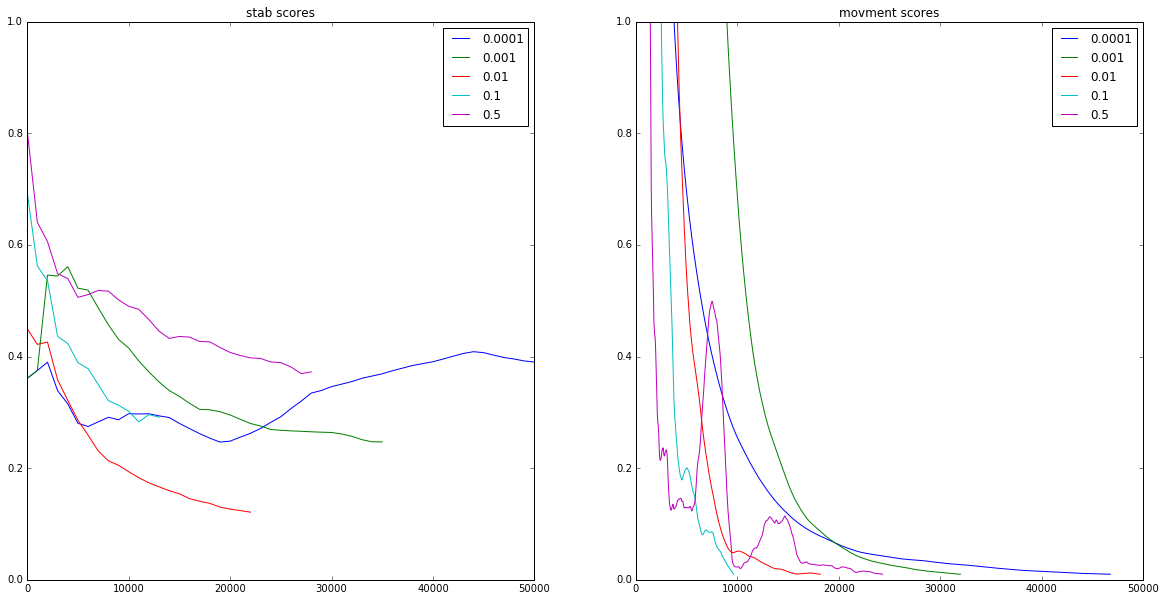

In [21]:
tmax = 70000
etas = [0.0001, 0.001, 0.01, 0.1, 0.5]
plt.figure(figsize=(20,10))
ax_stab = plt.subplot(1, 2, 1)
ax_mvnt = plt.subplot(1, 2, 2)
ax_stab.set_ylim(top=1)
ax_mvnt.set_ylim(top=1)
ax_stab.set_title("stab scores")
ax_mvnt.set_title("movment scores")

stab_axis = []
mvnt_axis = []

for e in etas:
    print("\n----------------------------------")
    print("Eta:", e)
    (stab_scores, center_movment_scores) = kohonen(max_iter=tmax, R=0, init_eta=e, init_sigma=3.0,
                                                   W_movement = 4000,
                                                   movment_limit = 0.01,
                                                   stab_limit=0,
                                                   learning_rate_fun = lambda x: x)
    
    s_l, = ax_stab.plot([v[1] for v in stab_scores], [v[0] for v in stab_scores])
    m_l, = ax_mvnt.plot(center_movment_scores)
    stab_axis.append(s_l)
    mvnt_axis.append(s_l)

legnd = [str(e) for e in etas]

ax_stab.legend(stab_axis, legnd, loc=1)
ax_mvnt.legend(mvnt_axis, legnd, loc=1)


----------------------------------
Eta: 0.0001


/home/lukas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[0 1 2 9]
nbr samples:  40
mov window: 4000
..........
 998 > stab score: 0.3611111111111109..........
 1998 > stab score: 0.46875..........
 2998 > stab score: 0.5460000000000005..........
 3998 > stab score: 0.46388888888888874..........
 4998 > stab score: 0.4091836734693879 > movment score: 6.96649627848..........
 5998 > stab score: 0.3609375 > movment score: 2.21602527198..........
 6998 > stab score: 0.337037037037037 > movment score: 1.14969325683..........
 7998 > stab score: 0.32399999999999984 > movment score: 0.732434305256..........
 8998 > stab score: 0.32975206611570224 > movment score: 0.521937354643..........
 9998 > stab score: 0.3364583333333334 > movment score: 0.396668172045..........
 10998 > stab score: 0.343491124260355 > movment score: 0.31471229931..........
 11998 > stab score: 0.34515306122448963 > movment score: 0.255485069127..........
 12998 > stab score: 0.34733333333333316 > movment score: 0.210166807875..........
 13998 > stab score: 0.3404296875 > mov

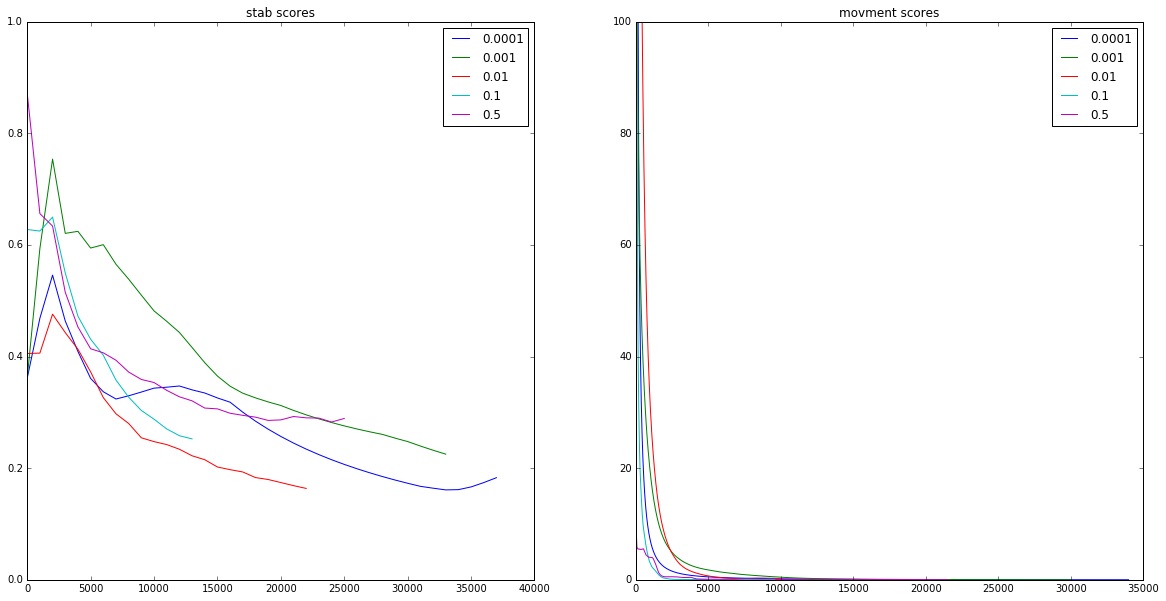

In [22]:
tmax = 70000
etas = [0.0001, 0.001, 0.01, 0.1, 0.5]
plt.figure(figsize=(20,10))
ax_stab = plt.subplot(1, 2, 1)
ax_mvnt = plt.subplot(1, 2, 2)
ax_stab.set_ylim(top=1)
ax_mvnt.set_ylim(top=100)
ax_stab.set_title("stab scores")
ax_mvnt.set_title("movment scores")

stab_axis = []
mvnt_axis = []

for e in etas:
    print("\n----------------------------------")
    print("Eta:", e)
    (stab_scores, center_movment_scores) = kohonen(max_iter=tmax, R=0, init_eta=e, init_sigma=3.0,
                                                   W_movement = 4000,
                                                   movment_limit = 0.01,
                                                   stab_limit=0,
                                                   learning_rate_fun = lambda x: x)
    
    s_l, = ax_stab.plot([v[1] for v in stab_scores], [v[0] for v in stab_scores])
    m_l, = ax_mvnt.plot(center_movment_scores)
    stab_axis.append(s_l)
    mvnt_axis.append(s_l)

legnd = [str(e) for e in etas]

ax_stab.legend(stab_axis, legnd, loc=1)
ax_mvnt.legend(mvnt_axis, legnd, loc=1)


----------------------------------
Eta: 0.0001


/home/lukas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[0 1 2 9]
nbr samples:  40
mov window: 4000
..........
 998 > stab score: 0.361111111111111 > sigma: 2.714770157691436..........
 1998 > stab score: 0.40625 > sigma: 2.4564133371303574..........
 2998 > stab score: 0.47400000000000037 > sigma: 2.222643587611492..........
 3998 > stab score: 0.4624999999999999 > sigma: 2.011121028727878..........
 4998 > stab score: 0.47551020408163225 > movment score: 12.0851140457 > sigma: 1.8197284597203067..........
 5998 > stab score: 0.46953125 > movment score: 5.87167489335 > sigma: 1.6465501676995817..........
 6998 > stab score: 0.4753086419753082 > movment score: 3.97464133223 > sigma: 1.489852752628941..........
 7998 > stab score: 0.47349999999999975 > movment score: 3.02023727113 > sigma: 1.3480677771374232..........
 8998 > stab score: 0.4743801652892562 > movment score: 2.39938723634 > sigma: 1.219776067500306..........
 9998 > stab score: 0.4642361111111108 > movment score: 1.94711063578 > sigma: 1.1036935086497832..........
 10998 > sta

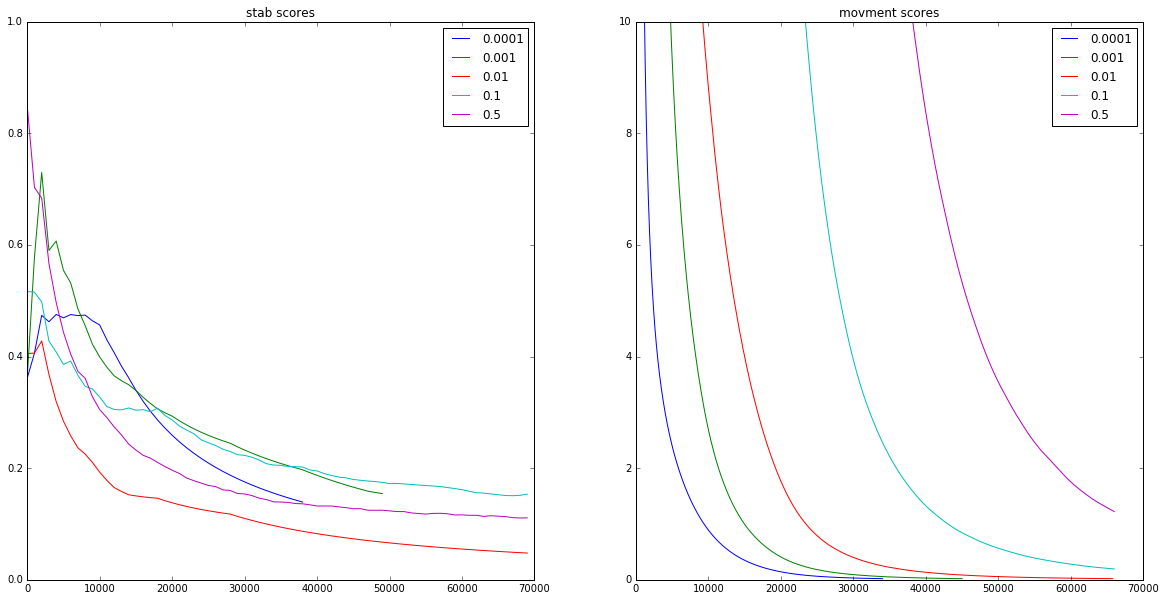

In [31]:
tmax = 70000
etas = [0.0001, 0.001, 0.01, 0.1, 0.5]
plt.figure(figsize=(20,10))
ax_stab = plt.subplot(1, 2, 1)
ax_mvnt = plt.subplot(1, 2, 2)
ax_stab.set_ylim(top=1)
ax_mvnt.set_ylim(top=10)
ax_stab.set_title("stab scores")
ax_mvnt.set_title("movment scores")

stab_axis = []
mvnt_axis = []

for e in etas:
    print("\n----------------------------------")
    print("Eta:", e)
    (stab_scores, center_movment_scores) = kohonen(max_iter=tmax, R=0, init_eta=e, init_sigma=3.0,
                                                   W_movement = 4000,
                                                   movment_limit = 0.05,
                                                   stab_limit=0,
                                                   learning_rate_fun = lambda x: x,
                                                   sigma_fun = lambda x: x)
    
    s_l, = ax_stab.plot([v[1] for v in stab_scores], [v[0] for v in stab_scores])
    m_l, = ax_mvnt.plot(center_movment_scores)
    stab_axis.append(s_l)
    mvnt_axis.append(s_l)

legnd = [str(e) for e in etas]

ax_stab.legend(stab_axis, legnd, loc=1)
ax_mvnt.legend(mvnt_axis, legnd, loc=1)


----------------------------------
Eta: 0.0001


/home/lukas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[0 1 2 9]
nbr samples:  40
mov window: 4000
..........
 998 > stab score: 0.361111111111111 > sigma: 3.0..........
 1998 > stab score: 0.390625 > sigma: 3.0..........
 2998 > stab score: 0.4180000000000003 > sigma: 3.0..........
 3998 > stab score: 0.3597222222222221 > sigma: 3.0..........
 4998 > stab score: 0.3724489795918369 > movment score: 6.9491966903 > sigma: 3.0..........
 5998 > stab score: 0.42421875 > movment score: 2.79463719226 > sigma: 2.79624641655..........
 6998 > stab score: 0.4796296296296294 > movment score: 2.02987235997 > sigma: 2.02998274159..........
 7998 > stab score: 0.5034999999999997 > movment score: 2.21160559848 > sigma: 2.02279803249..........
 8998 > stab score: 0.5537190082644627 > movment score: 2.42279980452 > sigma: 2.02279803249..........
 9998 > stab score: 0.5520833333333333 > movment score: 2.14215327781 > sigma: 2.02279803249..........
 10998 > stab score: 0.5565088757396451 > movment score: 1.49582899501 > sigma: 1.49630422541..........
 11998

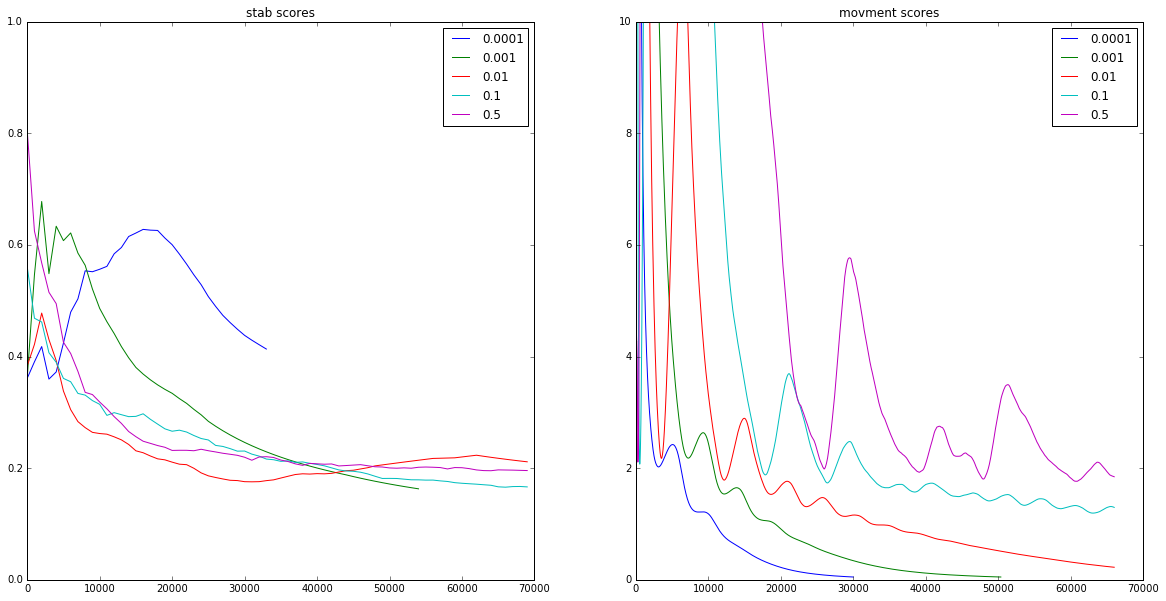

In [36]:
# TEST of setting sigma = eta

tmax = 70000
etas = [0.0001, 0.001, 0.01, 0.1, 0.5]
plt.figure(figsize=(20,10))
ax_stab = plt.subplot(1, 2, 1)
ax_mvnt = plt.subplot(1, 2, 2)
ax_stab.set_ylim(top=1)
ax_mvnt.set_ylim(top=10)
ax_stab.set_title("stab scores")
ax_mvnt.set_title("movment scores")

stab_axis = []
mvnt_axis = []

for e in etas:
    print("\n----------------------------------")
    print("Eta:", e)
    (stab_scores, center_movment_scores) = kohonen(max_iter=tmax, R=0, init_eta=e, init_sigma=3.0,
                                                   W_movement = 4000,
                                                   movment_limit = 0.05,
                                                   stab_limit=0,
                                                   learning_rate_fun = lambda x: x,
                                                   sigma_fun = lambda x, eta: eta if eta < x else x)
    
    s_l, = ax_stab.plot([v[1] for v in stab_scores], [v[0] for v in stab_scores])
    m_l, = ax_mvnt.plot(center_movment_scores)
    stab_axis.append(s_l)
    mvnt_axis.append(s_l)

legnd = [str(e) for e in etas]

ax_stab.legend(stab_axis, legnd, loc=1)
ax_mvnt.legend(mvnt_axis, legnd, loc=1)